In [3]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium 
import requests
import json
import time
import dill
import os

## Data preparation

### Shapefile reading

In [5]:
# Set filepath
# fp = "/workspaces/codespaces-jupyter/data/North California/gis_osm_traffic_free_1.shp"
fp = 'data/North California/gis_osm_traffic_free_1.shp'
traffic_locations = gpd.read_file(fp)

In [6]:
# Set filepath
# fp = "/workspaces/codespaces-jupyter/data/County of Santa Clara/geo_export_742a7eac-9364-4734-a083-fd8f554cf8ca.shp"
fp = "data/County of Santa Clara/geo_export_742a7eac-9364-4734-a083-fd8f554cf8ca.shp"
santa_clara_county_boundaries = gpd.read_file(fp)

### Santa Clara data extraction

In [16]:
# ------------------------------------------- take transport location within santa clara county boundaries -------------------------------------------
# take epsg from traffic_locations
epsg = traffic_locations.crs.to_epsg()
# uniform epsg of traffic_locations and santa_clara_county_boundaries
santa_clara_county_boundaries = santa_clara_county_boundaries.to_crs(epsg= epsg)
# take transport location within santa clara county boundaries
traffic_location_is_in_santa_clara = traffic_locations.apply(lambda x: gpd.GeoSeries(x.geometry, crs=4326).within(santa_clara_county_boundaries), axis=1)
traffic_locations['traffic_location_is_in_santa_clara'] = traffic_location_is_in_santa_clara

In [33]:
santa_clara_traffic_locations = traffic_locations.where(traffic_locations.traffic_location_is_in_santa_clara == True) \
.dropna(how = "all", subset = traffic_locations.columns) \
.drop(labels='traffic_location_is_in_santa_clara', axis=1)

In [34]:
santa_clara_traffic_locations 

osm_id    code             fclass name   
1            302889  5206.0  motorway_junction  NaN  \
4          25457926  5206.0  motorway_junction  NaN   
5          25457938  5201.0    traffic_signals  NaN   
6          25457939  5201.0    traffic_signals  NaN   
7          26027688  5201.0    traffic_signals  NaN   
...             ...     ...                ...  ...   
368287  10773975716  5204.0           crossing  NaN   
368300  10774066626  5204.0           crossing  NaN   
368301  10774115793  5204.0           crossing  NaN   
368302  10774115795  5204.0           crossing  NaN   
368303  10774115796  5204.0           crossing  NaN   

                           geometry  
1       POINT (-122.05079 37.32565)  
4       POINT (-121.55593 36.99915)  
5       POINT (-121.55391 37.00787)  
6       POINT (-121.55078 37.00208)  
7       POINT (-122.01778 37.35591)  
...                             ...  
368287  POINT (-121.93594 37.35282)  
368300  POINT (-121.93113 37.24468)  
368301  POINT (-121.85509 37.40253)  
368302  POINT (-121.85585 37.40219)  
368303  POINT (-121.85579 37.40231)  

[71886 rows x 5 columns]

### Santa Clara data saving

In [38]:
santa_clara_traffic_locations.to_file("data/County of Santa Clara/santa_clara_traffic_locations.geojson", driver='GeoJSON')

### Santa Clara data reading

In [39]:
santa_clara_traffic_locations = gpd.read_file("data/County of Santa Clara/santa_clara_traffic_locations.geojson")

### Santa Clara data cleaning

In [40]:
santa_clara_traffic_locations.fclass.value_counts()

fclass
crossing               45782
stop                    9712
turning_circle          8475
traffic_signals         4533
street_lamp             1353
parking_bicycle         1172
motorway_junction        535
parking                  122
fuel                     117
mini_roundabout           23
dam                       19
slipway                   14
waterfall                 10
parking_underground        8
weir                       6
parking_multistorey        3
speed_camera               1
pier                       1
Name: count, dtype: int64

<Axes: xlabel='fclass'>

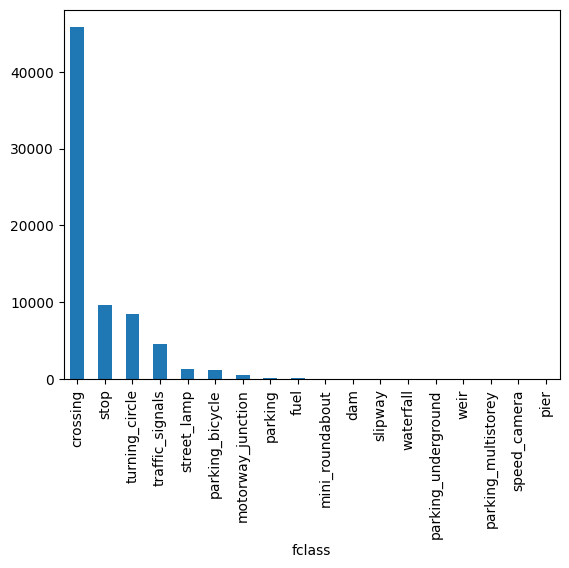

In [41]:
santa_clara_traffic_locations.fclass.value_counts().plot(kind='bar')

In [47]:
santa_clara_traffic_locations_clean = santa_clara_traffic_locations \
    .where(santa_clara_traffic_locations.fclass.apply(lambda x: x in ["crossing", "stop", "turning_circle"])) \
    .dropna(how = "all", subset = santa_clara_traffic_locations.columns)

### Santa clara data visualization

In [62]:
# --------------------------------------------------------------------------- OpenStreetMap --------------------------------------------------------------------
# create a list of 3 colors, one for every fclass
colors = ["blue", "red", "green"]

# map colors to fclass
cmap = {fclass: colors[i] for i, fclass in enumerate(santa_clara_traffic_locations_clean.fclass.unique())}

# Create a geometry list from the GeoDataFrame
geo_df_list = [tuple([point[4].xy[1][0], point[4].xy[0][0], point[2]]) for point in santa_clara_traffic_locations_clean.sample(10000).values]

# Create a folium map
map_ = folium.Map(location=[37.335480, -121.893028], tiles="OpenStreetMap", zoom_start=10)

# Add a circle marker to the map representing each point of the GeoDataFrame
for point in range(len(geo_df_list)):
    folium.Circle(geo_df_list[point][0:2], fill=True, radius = 5, color=cmap[geo_df_list[point][2]]).add_to(map_)
map_